We first impor the necessary libraries. 

In [2]:
import torch
import os, sys
from torch import nn
import math
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import mosek
from scipy.stats import chi2

Define the discriminator neurla network. 

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(201, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

Training the discriminator:

In [4]:

torch.manual_seed(111)
d=200 ##number of features
th0=torch.normal(0,1,[d,1])
th1=-2*th0
train_data_length = 4096*16 ##number of training samples to train the discriminator
feature_data=torch.normal(0,1,[train_data_length,d])
heta_val=1/(1+torch.exp(feature_data@th1))
eta_val=1/(1+torch.exp(feature_data@th0))
label_data = (torch.rand([train_data_length, 1]) <eta_val).long()
tmp=torch.rand([train_data_length,1])
w = 2 * tmp * label_data* heta_val - label_data * heta_val - tmp * heta_val - label_data * tmp + tmp + heta_val
train_data=torch.cat((feature_data,w),1)
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
    )
discriminator = Discriminator()
lr = 0.001 ##learning rate
num_epochs = 100
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        generated_features=torch.normal(0,1,[batch_size,d])
        generated_unif=torch.rand([batch_size,1])
        generated_samples = torch.cat((generated_features,generated_unif),1)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

            # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()


            # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")


    
    

Epoch: 0 Loss D.: 0.6938138604164124
Epoch: 10 Loss D.: 0.17667104303836823
Epoch: 20 Loss D.: 0.1493140459060669
Epoch: 30 Loss D.: 0.15186679363250732
Epoch: 40 Loss D.: 0.16040094196796417
Epoch: 50 Loss D.: 0.15120142698287964
Epoch: 60 Loss D.: 0.19318166375160217
Epoch: 70 Loss D.: 0.08731723576784134
Epoch: 80 Loss D.: 0.16278113424777985
Epoch: 90 Loss D.: 0.09410787373781204


We then plot the histogram of discriminator values on fake and real data:

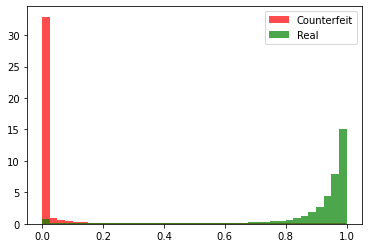

In [5]:
###Evaluating the discriminator performance
test_size = 100000
d=200 ##number of features
test_feature_data = torch.normal(0, 1, [test_size, d])
test_feature_data_2 = torch.normal(0, 1, [test_size, d])
test_heta_val = 1 / (1 + torch.exp(test_feature_data @ th1))
test_eta_val = 1 / (1 + torch.exp(test_feature_data @ th0))
test_label_data = (torch.rand([test_size, 1]) < test_eta_val).long()
tmp = torch.rand([test_size, 1])
test_w = 2 * tmp * test_label_data * test_heta_val - test_label_data * test_heta_val - tmp * test_heta_val - test_label_data * tmp + tmp + test_heta_val
test_data = torch.cat((test_feature_data, test_w), 1)
fake_data = torch.cat((test_feature_data_2, torch.rand(test_size, 1)), 1)
num_bins = 40
##fake data in green
plt.hist(np.array(discriminator(fake_data).detach()), num_bins,
         density=1,
         color='red',
         alpha=0.7,
        label='Counterfeit')

plt.hist(np.array(discriminator(test_data).detach()), num_bins,
         density=1,
         color='green',
         alpha=0.7,
        label='Real')
plt.legend(loc='upper right')
plt.show()

In the next step, we do the hypothesis testing for different score functions and optimizations. 

In [8]:
#computing test statistic V
torch.manual_seed(111)
alpha=0.1
N_exp=100
flag=0
K = 1
L = 50
M = K * L - 1
n = 5000

tau_tv_asym=0.8
tau_tv_finite=0.7
tau_kl_asym=1.81
tau_kl_finite=1.51
tau_hlg_asym=1.03
tau_hlg_finite=0.8

tau_tv_asym_simple=0.73
tau_tv_finite_simple=0.62
tau_kl_asym_simple=1.59
tau_kl_finite_simple=1.19
tau_hlg_asym_simple=0.73
tau_hlg_finite_simple=0.5

reject_tv_asym=0
reject_tv_finite=0
reject_kl_asym=0
reject_kl_finite=0
reject_hlg_asym=0
reject_hlg_finite=0

reject_tv_asym_simple=0
reject_tv_finite_simple=0
reject_kl_asym_simple=0
reject_kl_finite_simple=0
reject_hlg_asym_simple=0
reject_hlg_finite_simple=0



for counter in range(N_exp): 
    print(counter)
    X = torch.normal(0, 1, [n, d])
    heta_val = 1 / (1 + torch.exp(X @ th1))
    eta_val = 1 / (1 + torch.exp(X @ th0))
    Y = (torch.rand([n, 1]) < eta_val).long()
    tmp = torch.rand([n, 1])
    w = 2 * tmp * Y * heta_val - Y * heta_val - tmp * heta_val - Y * tmp + tmp + heta_val
    original_scores = discriminator(torch.cat((X, w), 1))
    original_scores_simple=(w <= heta_val).long() * 0.5 / heta_val + (w >= heta_val).long() * (0.5) / (1-heta_val)
    
    
    
    counterfeit_scores = torch.squeeze(
    torch.stack([discriminator(torch.cat((torch.normal(0, 1, [M, d]), torch.rand(M, 1)), 1)) for i in range(n)]))
    
    heta_val_c=torch.squeeze(
        torch.stack( [1/(1+torch.exp(torch.normal(0, 1, [M, d])@th1)) for i in range(n) ] ))
    w_c=torch.rand(n, M)
    counterfeit_scores_simple=(w_c <= heta_val_c).long() * 0.5 / heta_val_c + (w_c >= heta_val_c).long() * (0.5) / (1-heta_val_c)
    
    #print(heta_val_c.size())  =n * M
    #print(counterfeit_scores_simple.size())= n*M
    
    
    rank_val = torch.sum( (original_scores > counterfeit_scores).long(), 1)
    rank_val_simple=torch.sum( (original_scores_simple > counterfeit_scores_simple).long(), 1)
    labels = torch.floor(rank_val / K) + 1;
    labels_simple=torch.floor(rank_val_simple / K) + 1;
    my_label = labels.cpu().detach().numpy().astype(int)
    my_label_simple = labels_simple.cpu().detach().numpy().astype(int)
    V = np.zeros(L).astype(int)
    V_simple=np.zeros(L).astype(int)
    for ell in range(L):
        V[ell] = np.sum(my_label == (ell + 1))
        V_simple[ell]=np.sum(my_label_simple == (ell + 1))
    
    ##tv_asym
    my_p = cp.Variable(L)
    objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V, V)) / n))
    constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.norm(my_p - 1 / L, 1) <= 2 * tau_tv_asym]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='MOSEK', verbose=False)
    if(prob.status != 'optimal'):
        falg=1
    T_tv_asym = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / my_p.value)
    if T_tv_asym>=chi2.ppf(1-alpha, L-1):
        reject_tv_asym=reject_tv_asym+1
        
    ##tv_asym_simple   
    my_p = cp.Variable(L)
    objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V_simple, V_simple)) / n))
    constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.norm(my_p - 1 / L, 1) <= 2 * tau_tv_asym_simple]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='MOSEK', verbose=False)
    if(prob.status != 'optimal'):
        falg=1
    T_tv_asym = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) / my_p.value)
    if T_tv_asym>=chi2.ppf(1-alpha, L-1):
        reject_tv_asym_simple=reject_tv_asym_simple+1    
        
        
    ##tv_finite
    my_p = cp.Variable(L)
    obj=0
    for i in range(L):
         obj=obj+(1/L)*cp.quad_over_lin(V[i]/n-my_p[i], 1/L + my_p[i] )
    objective = cp.Minimize(obj)
    constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.norm(my_p - 1 / L, 1) <= 2 * tau_tv_finite]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='MOSEK', verbose=False)
    if(prob.status != 'optimal'):
        falg=1
    T_tv_finite = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / (my_p.value+1/L) )
    if T_tv_finite>=L+np.sqrt(2*L/alpha):
        reject_tv_finite=reject_tv_finite+1
        
    
    ##tv_finite_simple
    my_p = cp.Variable(L)
    obj=0
    for i in range(L):
         obj=obj+(1/L)*cp.quad_over_lin(V_simple[i]/n-my_p[i], 1/L + my_p[i] )
    objective = cp.Minimize(obj)
    constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.norm(my_p - 1 / L, 1) <= 2 * tau_tv_finite_simple]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='MOSEK', verbose=False)
    if(prob.status != 'optimal'):
        falg=1
    T_tv_finite = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) / (my_p.value+1/L))
    if T_tv_finite>=L+np.sqrt(2*L/alpha):
        reject_tv_finite_simple=reject_tv_finite_simple+1
        
    ##kl_asym
    my_p = cp.Variable(L)
    objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V, V)) / n))
    constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau_kl_asym]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='MOSEK', verbose=False)
    if(prob.status != 'optimal'):
        falg=1
    T_kl_asym = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / my_p.value)
    if T_kl_asym>=chi2.ppf(1-alpha, L-1):
        reject_kl_asym=reject_kl_asym+1
        
   
    ##kl_asym_simple
    my_p = cp.Variable(L)
    objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V_simple, V_simple)) / n))
    constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau_kl_asym_simple]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='MOSEK', verbose=False)
    if(prob.status != 'optimal'):
        falg=1
    T_kl_asym = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) / my_p.value)
    if T_kl_asym>=chi2.ppf(1-alpha, L-1):
        reject_kl_asym_simple=reject_kl_asym_simple+1
    
    
    
    ##kl_finite
    my_p = cp.Variable(L)
    obj=0
    for i in range(L):
         obj=obj+(1/L)*cp.quad_over_lin(V[i]/n-my_p[i], 1/L + my_p[i] )
    objective = cp.Minimize(obj)
    constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau_kl_finite]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='MOSEK', verbose=False)
    if(prob.status != 'optimal'):
        falg=1
    T_kl_finite = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / (my_p.value+1/L))
    if T_kl_finite>=L+np.sqrt(2*L/alpha):
        reject_kl_finite=reject_kl_finite+1
        
        
    ##kl_finite_simple
    my_p = cp.Variable(L)
    obj=0
    for i in range(L):
         obj=obj+(1/L)*cp.quad_over_lin(V_simple[i]/n-my_p[i], 1/L + my_p[i] )
    objective = cp.Minimize(obj)
    constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau_kl_finite_simple]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='MOSEK', verbose=False)
    if(prob.status != 'optimal'):
        falg=1
    T_kl_finite = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) /(my_p.value+1/L))
    if T_kl_finite>=L+np.sqrt(2*L/alpha):
        reject_kl_finite_simple=reject_kl_finite_simple+1
        
        
        
    ##Hlg_asym
    my_p = cp.Variable(L)
    objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V, V)) / n))
    constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.sqrt(my_p))>= cp.sqrt(L) * (1-tau_hlg_asym/2)]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='MOSEK', verbose=False)
    if(prob.status != 'optimal'):
        falg=1
    T_hlg_asym = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / my_p.value)
    if T_hlg_asym>=chi2.ppf(1-alpha, L-1):
        reject_hlg_asym=reject_hlg_asym+1
    
    ##HLG_asym_simple   
    my_p = cp.Variable(L)
    objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V_simple, V_simple)) / n))
    constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.sqrt(my_p))>= cp.sqrt(L) * (1-tau_hlg_asym_simple/2)]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='MOSEK', verbose=False)
    if(prob.status != 'optimal'):
        falg=1
    T_hlg_asym = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) / my_p.value)
    if T_hlg_asym>=chi2.ppf(1-alpha, L-1):
        reject_hlg_asym_simple=reject_hlg_asym_simple+1  
        
        
    ##Hlg_finite
    my_p = cp.Variable(L)
    obj=0
    for i in range(L):
         obj=obj+(1/L)*cp.quad_over_lin(V[i]/n-my_p[i], 1/L + my_p[i] )
    objective = cp.Minimize(obj)
    constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.sqrt(my_p))>= cp.sqrt(L) * (1-tau_hlg_finite/2)]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='MOSEK', verbose=False)
    if(prob.status != 'optimal'):
        falg=1
    T_hlg_finite = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / (my_p.value+1/L))
    if T_hlg_finite>=L+np.sqrt(2*L/alpha):
        reject_hlg_finite=reject_hlg_finite+1
        
    
    ##Hlg_finite_simple
    my_p = cp.Variable(L)
    obj=0
    for i in range(L):
         obj=obj+(1/L)*cp.quad_over_lin(V_simple[i]/n-my_p[i], 1/L + my_p[i] )
    objective = cp.Minimize(obj)
    constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.sqrt(my_p))>= cp.sqrt(L) * (1-tau_hlg_finite_simple/2)]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='MOSEK', verbose=False)
    if(prob.status != 'optimal'):
        falg=1
    T_hlg_finite = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) /(my_p.value+1/L))
    if T_hlg_finite>=L+np.sqrt(2*L/alpha):
        reject_hlg_finite_simple=reject_hlg_finite_simple+1
        
    
    
        
    
    
    
if(flag==1):
    print("ERROR in CVX")
    
print(reject_tv_asym/N_exp,
      reject_tv_asym_simple/N_exp,
      "\n",
      reject_tv_finite/N_exp,
      reject_tv_finite_simple/N_exp,
      "\n",
      reject_kl_asym/N_exp,
      reject_kl_asym_simple/N_exp,
      "\n",
      reject_kl_finite/N_exp,
      reject_kl_finite_simple/N_exp,
      "\n",
      reject_hlg_asym/N_exp,
      reject_hlg_asym_simple/N_exp,
      "\n",
      reject_hlg_finite/N_exp,
      reject_hlg_finite_simple/N_exp)
        
        
    

    




    
















0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1.0 0.0 
 1.0 0.0 
 1.0 0.0 
 1.0 0.0 
 1.0 0.0 
 1.0 0.0


1.2
1.25
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.5500000000000003
1.6000000000000003
1.6500000000000004
1.7000000000000004
1.7500000000000004
1.8000000000000005
1.8500000000000005
1.9000000000000006
1.9500000000000006
2.000000000000001
2.0500000000000007
2.1000000000000005
2.150000000000001
2.200000000000001
2.250000000000001
2.3000000000000007
2.350000000000001
2.4000000000000012
2.450000000000001
2.500000000000001
2.550000000000001
2.6000000000000014
2.6500000000000012
2.700000000000001
2.7500000000000013


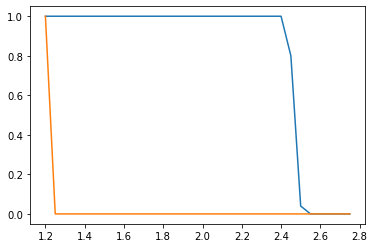

In [34]:
#computing test statistic V
torch.manual_seed(111)
alpha=0.1
N_exp=50
flag=0
K = 1
L = 50
M = K * L - 1
n = 5000

tau_tv_asym=0.8
tau_tv_finite=0.7
tau_kl_asym=1.81
tau_kl_finite=1.51
tau_hlg_asym=1.03
tau_hlg_finite=0.8

tau_tv_asym_simple=0.73
tau_tv_finite_simple=0.62
tau_kl_asym_simple=1.59
tau_kl_finite_simple=1.19
tau_hlg_asym_simple=0.73
tau_hlg_finite_simple=0.5

reject_tv_asym=0
reject_tv_finite=0
reject_kl_asym=0
reject_kl_finite=0
reject_hlg_asym=0
reject_hlg_finite=0

reject_tv_asym_simple=0
reject_tv_finite_simple=0
reject_kl_asym_simple=0
reject_kl_finite_simple=0
reject_hlg_asym_simple=0
reject_hlg_finite_simple=0


#tau_vals=np.array([1.00,1.05,1.1,1.15,1.2,1.25,
#                       1.3,1.35,1.4,1.45,1.50,1.55,1.6,1.65,1.7,1.75,1.8,1.85,1.9,1.95,2.00])
tau_vals=np.arange(1.2, 2.8, 0.05)


#tau_vals=np.array([2.6,2.8,3])
result_kl_asym=np.zeros(0)
result_kl_asym_simple=np.zeros(0)

for tau in tau_vals: 
    reject_kl_asym=0
    reject_kl_asym_simple=0
    print(tau)
    for counter in range(N_exp): 
        X = torch.normal(0, 1, [n, d])
        heta_val = 1 / (1 + torch.exp(X @ th1))
        eta_val = 1 / (1 + torch.exp(X @ th0))
        Y = (torch.rand([n, 1]) < eta_val).long()
        tmp = torch.rand([n, 1])
        w = 2 * tmp * Y * heta_val - Y * heta_val - tmp * heta_val - Y * tmp + tmp + heta_val
        original_scores = discriminator(torch.cat((X, w), 1))
        original_scores_simple=(w <= heta_val).long() * 0.5 / heta_val + (w >= heta_val).long() * (0.5) / (1-heta_val)
        counterfeit_scores = torch.squeeze(
            torch.stack([discriminator(torch.cat((torch.normal(0, 1, [M, d]), torch.rand(M, 1)), 1)) for i in range(n)]))
        heta_val_c=torch.squeeze(
        torch.stack( [1/(1+torch.exp(torch.normal(0, 1, [M, d])@th1)) for i in range(n) ] ))
        w_c=torch.rand(n, M)
        counterfeit_scores_simple=(w_c <= heta_val_c).long() * 0.5 / heta_val_c + (w_c >= heta_val_c).long() * (0.5) / (1-heta_val_c)
        rank_val = torch.sum( (original_scores > counterfeit_scores).long(), 1)
        rank_val_simple=torch.sum( (original_scores_simple > counterfeit_scores_simple).long(), 1)
        labels = torch.floor(rank_val / K) + 1;
        labels_simple=torch.floor(rank_val_simple / K) + 1;
        my_label = labels.cpu().detach().numpy().astype(int)
        my_label_simple = labels_simple.cpu().detach().numpy().astype(int)
        V = np.zeros(L).astype(int)
        V_simple=np.zeros(L).astype(int)
        for ell in range(L):
            V[ell] = np.sum(my_label == (ell + 1))
            V_simple[ell]=np.sum(my_label_simple == (ell + 1))
        ##kl_asym
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V, V)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_asym = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / my_p.value)
        if T_kl_asym>=chi2.ppf(1-alpha, L-1):
            reject_kl_asym=reject_kl_asym+1
        ##kl_asym_simple
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V_simple, V_simple)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_asym = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) / my_p.value)
        if T_kl_asym>=chi2.ppf(1-alpha, L-1):
            reject_kl_asym_simple=reject_kl_asym_simple+1
    result_kl_asym=np.append(result_kl_asym,reject_kl_asym/N_exp)
    result_kl_asym_simple=np.append(result_kl_asym_simple,reject_kl_asym_simple/N_exp)
    
            
        

plt.plot(tau_vals,result_kl_asym)
plt.plot(tau_vals,result_kl_asym_simple)
plt.show()
            
        
    
    
    
    
    
    
    
    

        
        
    

    




    
















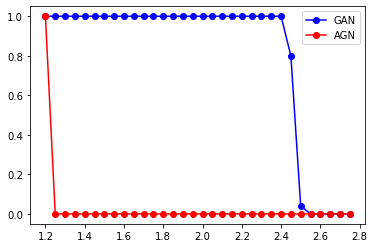

In [39]:
plt.plot(tau_vals,result_kl_asym,'bo-',label='GAN')
plt.plot(tau_vals,result_kl_asym_simple,'ro-',label='AGN')
plt.legend(loc='upper right')
plt.show()

            
        

In [26]:
b=np.append(b,1)
print(b)

[1. 1. 1.]


In [ ]:
plt.plot(tau_vals,resu)

1.2
1.21
1.22
1.23
1.24
1.25
2.4
2.4099999999999997
2.4199999999999995
2.4299999999999993
2.439999999999999
2.449999999999999
2.4599999999999986
2.4699999999999984
2.479999999999998
2.489999999999998
2.499999999999998
2.5099999999999976
2.5199999999999974
2.529999999999997
2.539999999999997


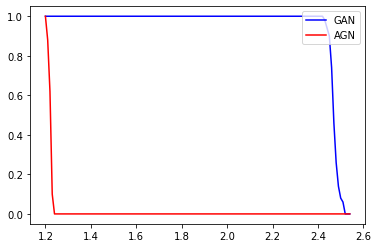

In [44]:
#computing test statistic V
torch.manual_seed(111)
alpha=0.1
N_exp=50
flag=0
K = 1
L = 50
M = K * L - 1
n = 5000

tau_tv_asym=0.8
tau_tv_finite=0.7
tau_kl_asym=1.81
tau_kl_finite=1.51
tau_hlg_asym=1.03
tau_hlg_finite=0.8

tau_tv_asym_simple=0.73
tau_tv_finite_simple=0.62
tau_kl_asym_simple=1.59
tau_kl_finite_simple=1.19
tau_hlg_asym_simple=0.73
tau_hlg_finite_simple=0.5

reject_tv_asym=0
reject_tv_finite=0
reject_kl_asym=0
reject_kl_finite=0
reject_hlg_asym=0
reject_hlg_finite=0

reject_tv_asym_simple=0
reject_tv_finite_simple=0
reject_kl_asym_simple=0
reject_kl_finite_simple=0
reject_hlg_asym_simple=0
reject_hlg_finite_simple=0


#tau_vals=np.array([1.00,1.05,1.1,1.15,1.2,1.25,
#                       1.3,1.35,1.4,1.45,1.50,1.55,1.6,1.65,1.7,1.75,1.8,1.85,1.9,1.95,2.00])
tau_vals=np.append(np.arange(1.2,1.25,0.01), np.arange(2.4, 2.55, 0.01))




#tau_vals=np.array([2.6,2.8,3])
result_kl_asym=np.zeros(0)
result_kl_asym_simple=np.zeros(0)

for tau in tau_vals: 
    reject_kl_asym=0
    reject_kl_asym_simple=0
    print(tau)
    for counter in range(N_exp): 
        X = torch.normal(0, 1, [n, d])
        heta_val = 1 / (1 + torch.exp(X @ th1))
        eta_val = 1 / (1 + torch.exp(X @ th0))
        Y = (torch.rand([n, 1]) < eta_val).long()
        tmp = torch.rand([n, 1])
        w = 2 * tmp * Y * heta_val - Y * heta_val - tmp * heta_val - Y * tmp + tmp + heta_val
        original_scores = discriminator(torch.cat((X, w), 1))
        original_scores_simple=(w <= heta_val).long() * 0.5 / heta_val + (w >= heta_val).long() * (0.5) / (1-heta_val)
        counterfeit_scores = torch.squeeze(
            torch.stack([discriminator(torch.cat((torch.normal(0, 1, [M, d]), torch.rand(M, 1)), 1)) for i in range(n)]))
        heta_val_c=torch.squeeze(
        torch.stack( [1/(1+torch.exp(torch.normal(0, 1, [M, d])@th1)) for i in range(n) ] ))
        w_c=torch.rand(n, M)
        counterfeit_scores_simple=(w_c <= heta_val_c).long() * 0.5 / heta_val_c + (w_c >= heta_val_c).long() * (0.5) / (1-heta_val_c)
        rank_val = torch.sum( (original_scores > counterfeit_scores).long(), 1)
        rank_val_simple=torch.sum( (original_scores_simple > counterfeit_scores_simple).long(), 1)
        labels = torch.floor(rank_val / K) + 1;
        labels_simple=torch.floor(rank_val_simple / K) + 1;
        my_label = labels.cpu().detach().numpy().astype(int)
        my_label_simple = labels_simple.cpu().detach().numpy().astype(int)
        V = np.zeros(L).astype(int)
        V_simple=np.zeros(L).astype(int)
        for ell in range(L):
            V[ell] = np.sum(my_label == (ell + 1))
            V_simple[ell]=np.sum(my_label_simple == (ell + 1))
        ##kl_asym
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V, V)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_asym = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / my_p.value)
        if T_kl_asym>=chi2.ppf(1-alpha, L-1):
            reject_kl_asym=reject_kl_asym+1
        ##kl_asym_simple
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V_simple, V_simple)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_asym = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) / my_p.value)
        if T_kl_asym>=chi2.ppf(1-alpha, L-1):
            reject_kl_asym_simple=reject_kl_asym_simple+1
    result_kl_asym=np.append(result_kl_asym,reject_kl_asym/N_exp)
    result_kl_asym_simple=np.append(result_kl_asym_simple,reject_kl_asym_simple/N_exp)
    
            
        
plt.plot(tau_vals,result_kl_asym,'b-',label='GAN')
plt.plot(tau_vals,result_kl_asym_simple,'r-',label='AGN')
plt.legend(loc='upper right')
plt.show()
    
    
    
    
    
    
    
    

        
        
    

    




    
















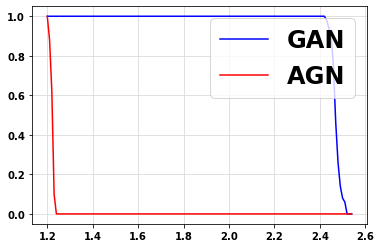

In [67]:
plt.plot(tau_vals,result_kl_asym,'b-',label='GAN')
plt.plot(tau_vals,result_kl_asym_simple,'r-',label='AGN')
plt.legend(loc='upper right')
plt.grid(axis='x', color='0.85')
plt.grid(axis='y', color='0.85')
plt.rc('axes', labelsize=18)
plt.rc('legend', fontsize=20)
plt.show()
    
    
    
    

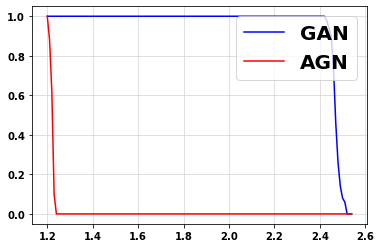

In [69]:
plt.plot(tau_vals,result_kl_asym,'b-',label='GAN')
plt.plot(tau_vals,result_kl_asym_simple,'r-',label='AGN')
plt.legend(loc='upper right')
plt.grid(axis='x', color='0.85')
plt.grid(axis='y', color='0.85')
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=20)
plt.show()
    

[0.65 0.67 0.69 0.71 0.73 0.75 0.77 0.79 0.81 0.83 0.85 0.87 0.89 0.91
 0.93 0.95 0.97 0.99 1.01 1.03 1.05 1.07 1.09 1.2  1.21 1.22 1.23 1.24
 1.25 2.1  2.11 2.12 2.13 2.14 2.15 2.16 2.17 2.18 2.19 2.2  2.21 2.22
 2.23 2.24 2.25 2.26 2.27 2.28 2.29 2.3  2.31 2.32 2.33 2.34 2.35 2.36
 2.37 2.38 2.39 2.4  2.42 2.44 2.46 2.48 2.5  2.52 2.54]
0.65
0.67
0.6900000000000001
0.7100000000000001
0.7300000000000001
0.7500000000000001
0.7700000000000001
0.7900000000000001
0.8100000000000002
0.8300000000000002
0.8500000000000002
0.8700000000000002
0.8900000000000002
0.9100000000000003
0.9300000000000003
0.9500000000000003
0.9700000000000003
0.9900000000000003
1.0100000000000002
1.0300000000000002
1.0500000000000003
1.0700000000000003
1.0900000000000003
1.2
1.21
1.22
1.23
1.24
1.25
2.1
2.11
2.1199999999999997
2.1299999999999994
2.1399999999999992
2.149999999999999
2.159999999999999
2.1699999999999986
2.1799999999999984
2.189999999999998
2.199999999999998
2.2099999999999977
2.2199999999999975
2.22999

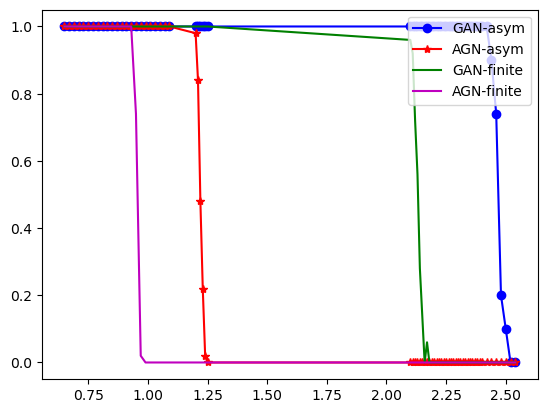

In [7]:
#computing test statistic V
torch.manual_seed(111)
alpha=0.1
N_exp=50
flag=0
K = 1
L = 50
M = K * L - 1
n = 5000

tau_tv_asym=0.8
tau_tv_finite=0.7
tau_kl_asym=1.81
tau_kl_finite=1.51
tau_hlg_asym=1.03
tau_hlg_finite=0.8

tau_tv_asym_simple=0.73
tau_tv_finite_simple=0.62
tau_kl_asym_simple=1.59
tau_kl_finite_simple=1.19
tau_hlg_asym_simple=0.73
tau_hlg_finite_simple=0.5

reject_tv_asym=0
reject_tv_finite=0
reject_kl_asym=0
reject_kl_finite=0
reject_hlg_asym=0
reject_hlg_finite=0

reject_tv_asym_simple=0
reject_tv_finite_simple=0
reject_kl_asym_simple=0
reject_kl_finite_simple=0
reject_hlg_asym_simple=0
reject_hlg_finite_simple=0


#tau_vals=np.array([1.00,1.05,1.1,1.15,1.2,1.25,
#                       1.3,1.35,1.4,1.45,1.50,1.55,1.6,1.65,1.7,1.75,1.8,1.85,1.9,1.95,2.00])
#tau_vals=np.append(np.arange(1.2,1.25,0.01), np.arange(2.4, 2.55, 0.01))
tau_tmp= [np.arange(0.65,1.1,0.02), np.arange(1.2,1.25,0.01),  np.arange(2.1, 2.4,0.01),np.arange(2.4, 2.55, 0.02)]
tau_vals= np.concatenate(tau_tmp).ravel()
print(tau_vals)



#tau_vals=np.array([2.6,2.8,3])
result_kl_asym=np.zeros(0)
result_kl_finite=np.zeros(0)
result_kl_asym_simple=np.zeros(0)
result_kl_finite_simple=np.zeros(0)


for tau in tau_vals: 
    reject_kl_asym=0
    reject_kl_asym_simple=0
    reject_kl_finite=0
    reject_kl_finite_simple=0
    print(tau)
    for counter in range(N_exp): 
        X = torch.normal(0, 1, [n, d])
        heta_val = 1 / (1 + torch.exp(X @ th1))
        eta_val = 1 / (1 + torch.exp(X @ th0))
        Y = (torch.rand([n, 1]) < eta_val).long()
        tmp = torch.rand([n, 1])
        w = 2 * tmp * Y * heta_val - Y * heta_val - tmp * heta_val - Y * tmp + tmp + heta_val
        original_scores = discriminator(torch.cat((X, w), 1))
        original_scores_simple=(w <= heta_val).long() * 0.5 / heta_val + (w >= heta_val).long() * (0.5) / (1-heta_val)
        counterfeit_scores = torch.squeeze(
            torch.stack([discriminator(torch.cat((torch.normal(0, 1, [M, d]), torch.rand(M, 1)), 1)) for i in range(n)]))
        heta_val_c=torch.squeeze(
        torch.stack( [1/(1+torch.exp(torch.normal(0, 1, [M, d])@th1)) for i in range(n) ] ))
        w_c=torch.rand(n, M)
        counterfeit_scores_simple=(w_c <= heta_val_c).long() * 0.5 / heta_val_c + (w_c >= heta_val_c).long() * (0.5) / (1-heta_val_c)
        rank_val = torch.sum( (original_scores > counterfeit_scores).long(), 1)
        rank_val_simple=torch.sum( (original_scores_simple > counterfeit_scores_simple).long(), 1)
        labels = torch.floor(rank_val / K) + 1;
        labels_simple=torch.floor(rank_val_simple / K) + 1;
        my_label = labels.cpu().detach().numpy().astype(int)
        my_label_simple = labels_simple.cpu().detach().numpy().astype(int)
        V = np.zeros(L).astype(int)
        V_simple=np.zeros(L).astype(int)
        for ell in range(L):
            V[ell] = np.sum(my_label == (ell + 1))
            V_simple[ell]=np.sum(my_label_simple == (ell + 1))
        ##kl_asym
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V, V)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_asym = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / my_p.value)
        if T_kl_asym>=chi2.ppf(1-alpha, L-1):
            reject_kl_asym=reject_kl_asym+1
        ##kl_asym_simple
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V_simple, V_simple)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_asym = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) / my_p.value)
        if T_kl_asym>=chi2.ppf(1-alpha, L-1):
            reject_kl_asym_simple=reject_kl_asym_simple+1
        
        
        ##kl_finite
        my_p = cp.Variable(L)
        obj=0
        for i in range(L):
                obj=obj+(1/L)*cp.quad_over_lin(V[i]/n-my_p[i], 1/L + my_p[i] )
        objective = cp.Minimize(obj)
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_finite = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / (my_p.value+1/L))
        if T_kl_finite>=L+np.sqrt(2*L/alpha):
            reject_kl_finite=reject_kl_finite+1
        ##kl_finite_simple
        my_p = cp.Variable(L)
        obj=0
        for i in range(L):
            obj=obj+(1/L)*cp.quad_over_lin(V_simple[i]/n-my_p[i], 1/L + my_p[i] )
        objective = cp.Minimize(obj)
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_finite = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) /(my_p.value+1/L))
        if T_kl_finite>=L+np.sqrt(2*L/alpha):
            reject_kl_finite_simple=reject_kl_finite_simple+1
        
    result_kl_asym=np.append(result_kl_asym,reject_kl_asym/N_exp)
    result_kl_asym_simple=np.append(result_kl_asym_simple,reject_kl_asym_simple/N_exp)
    result_kl_finite=np.append(result_kl_finite,reject_kl_finite/N_exp)
    result_kl_finite_simple=np.append(result_kl_finite_simple,reject_kl_finite_simple/N_exp)
    
            
        
plt.style.use(['default'])     
plt.plot(tau_vals,result_kl_asym,'bo-',label='GAN-asym')
plt.plot(tau_vals,result_kl_asym_simple,'r*-',label='AGN-asym')
plt.plot(tau_vals,result_kl_finite,'g-',label='GAN-finite')
plt.plot(tau_vals,result_kl_finite_simple,'m-',label='AGN-finite')
plt.legend(loc='upper right')
plt.show()
    
    
    
    
    
    
    

        
        
    

    




    
















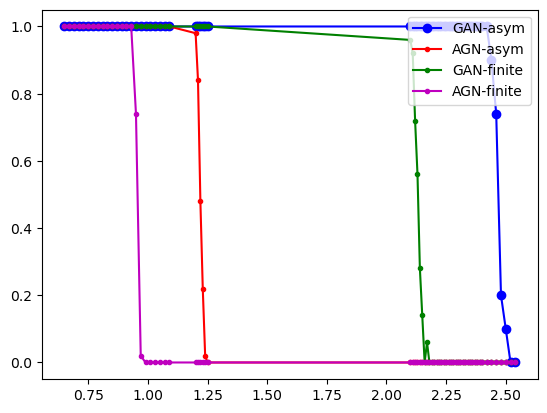

In [21]:
plt.style.use(['default'])     
plt.plot(tau_vals,result_kl_asym,'bo-',label='GAN-asym')
plt.plot(tau_vals,result_kl_asym_simple,'.r-',label='AGN-asym')
plt.plot(tau_vals,result_kl_finite,'.g-',label='GAN-finite')
plt.plot(tau_vals,result_kl_finite_simple,'.m-',label='AGN-finite')
plt.legend(loc='upper right')
plt.show()
    
    

In [ ]:
2+4

In [ ]:
print(2+4)

In [17]:
print(tau_vals,result_kl_finite)


[0.65 0.67 0.69 0.71 0.73 0.75 0.77 0.79 0.81 0.83 0.85 0.87 0.89 0.91
 0.93 0.95 0.97 0.99 1.01 1.03 1.05 1.07 1.09 1.2  1.21 1.22 1.23 1.24
 1.25 2.1  2.11 2.12 2.13 2.14 2.15 2.16 2.17 2.18 2.19 2.2  2.21 2.22
 2.23 2.24 2.25 2.26 2.27 2.28 2.29 2.3  2.31 2.32 2.33 2.34 2.35 2.36
 2.37 2.38 2.39 2.4  2.42 2.44 2.46 2.48 2.5  2.52 2.54] [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   0.96 0.92 0.72 0.56 0.28 0.14 0.   0.06 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]


In [18]:
print(flag)


0


In [27]:
np.savetxt("data_kll.csv",
           np.transpose(np.array([tau_vals,result_kl_asym,result_kl_asym_simple, result_kl_finite,result_kl_finite_simple])),
           delimiter=",",
          header="tau_vals,result_kl_asym,result_kl_asym_simple,result_kl_finite,result_kl_finite_simple",
          fmt='%.6f')

In [28]:
print(4+6)

10


[0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63
 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77
 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89]
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.5900000000000001
0.6000000000000001
0.6100000000000001
0.6200000000000001
0.6300000000000001
0.6400000000000001
0.6500000000000001
0.6600000000000001
0.6700000000000002
0.6800000000000002
0.6900000000000002
0.7000000000000002
0.7100000000000002
0.7200000000000002
0.7300000000000002
0.7400000000000002
0.7500000000000002
0.7600000000000002
0.7700000000000002
0.7800000000000002
0.7900000000000003
0.8000000000000003
0.8100000000000003
0.8200000000000003
0.8300000000000003
0.8400000000000003
0.8500000000000003
0.8600000000000003
0.8700000000000003
0.8800000000000003
0.8900000000000003


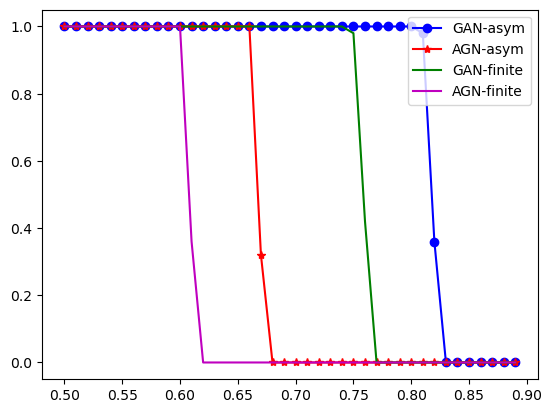

In [30]:
#computing test statistic V
torch.manual_seed(111)
alpha=0.1
N_exp=50
flag=0
K = 1
L = 50
M = K * L - 1
n = 5000






reject_tv_asym=0
reject_tv_finite=0

reject_tv_asym_simple=0
reject_tv_finite_simple=0



#tau_vals=np.array([1.00,1.05,1.1,1.15,1.2,1.25,
#                       1.3,1.35,1.4,1.45,1.50,1.55,1.6,1.65,1.7,1.75,1.8,1.85,1.9,1.95,2.00])
#tau_vals=np.append(np.arange(1.2,1.25,0.01), np.arange(2.4, 2.55, 0.01))
#tau_tmp= [np.arange(0.65,1.1,0.02), np.arange(1.2,1.25,0.01),  np.arange(2.1, 2.4,0.01),np.arange(2.4, 2.55, 0.02)]
#tau_vals= np.concatenate(tau_tmp).ravel()
tau_vals=np.arange(0.5,0.9,0.01)
print(tau_vals)



#tau_vals=np.array([2.6,2.8,3])
result_tv_asym=np.zeros(0)
result_tv_finite=np.zeros(0)
result_tv_asym_simple=np.zeros(0)
result_tv_finite_simple=np.zeros(0)


for tau in tau_vals: 
    reject_tv_asym=0
    reject_tv_asym_simple=0
    reject_tv_finite=0
    reject_tv_finite_simple=0
    print(tau)
    for counter in range(N_exp): 
        X = torch.normal(0, 1, [n, d])
        heta_val = 1 / (1 + torch.exp(X @ th1))
        eta_val = 1 / (1 + torch.exp(X @ th0))
        Y = (torch.rand([n, 1]) < eta_val).long()
        tmp = torch.rand([n, 1])
        w = 2 * tmp * Y * heta_val - Y * heta_val - tmp * heta_val - Y * tmp + tmp + heta_val
        original_scores = discriminator(torch.cat((X, w), 1))
        original_scores_simple=(w <= heta_val).long() * 0.5 / heta_val + (w >= heta_val).long() * (0.5) / (1-heta_val)
        counterfeit_scores = torch.squeeze(
            torch.stack([discriminator(torch.cat((torch.normal(0, 1, [M, d]), torch.rand(M, 1)), 1)) for i in range(n)]))
        heta_val_c=torch.squeeze(
        torch.stack( [1/(1+torch.exp(torch.normal(0, 1, [M, d])@th1)) for i in range(n) ] ))
        w_c=torch.rand(n, M)
        counterfeit_scores_simple=(w_c <= heta_val_c).long() * 0.5 / heta_val_c + (w_c >= heta_val_c).long() * (0.5) / (1-heta_val_c)
        rank_val = torch.sum( (original_scores > counterfeit_scores).long(), 1)
        rank_val_simple=torch.sum( (original_scores_simple > counterfeit_scores_simple).long(), 1)
        labels = torch.floor(rank_val / K) + 1;
        labels_simple=torch.floor(rank_val_simple / K) + 1;
        my_label = labels.cpu().detach().numpy().astype(int)
        my_label_simple = labels_simple.cpu().detach().numpy().astype(int)
        V = np.zeros(L).astype(int)
        V_simple=np.zeros(L).astype(int)
        for ell in range(L):
            V[ell] = np.sum(my_label == (ell + 1))
            V_simple[ell]=np.sum(my_label_simple == (ell + 1))
        ##tv_asym
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V, V)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.norm(my_p - 1 / L, 1) <= 2 * tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_tv_asym = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / my_p.value)
        if T_tv_asym>=chi2.ppf(1-alpha, L-1):
            reject_tv_asym=reject_tv_asym+1
        ##tv_asym_simple
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V_simple, V_simple)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.norm(my_p - 1 / L, 1) <= 2 * tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_tv_asym = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) / my_p.value)
        if T_tv_asym>=chi2.ppf(1-alpha, L-1):
            reject_tv_asym_simple=reject_tv_asym_simple+1
        
        
        ##tv_finite
        my_p = cp.Variable(L)
        obj=0
        for i in range(L):
                obj=obj+(1/L)*cp.quad_over_lin(V[i]/n-my_p[i], 1/L + my_p[i] )
        objective = cp.Minimize(obj)
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.norm(my_p - 1 / L, 1) <= 2 * tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_tv_finite = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / (my_p.value+1/L))
        if T_tv_finite>=L+np.sqrt(2*L/alpha):
            reject_tv_finite=reject_tv_finite+1
        ##tv_finite_simple
        my_p = cp.Variable(L)
        obj=0
        for i in range(L):
            obj=obj+(1/L)*cp.quad_over_lin(V_simple[i]/n-my_p[i], 1/L + my_p[i] )
        objective = cp.Minimize(obj)
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.norm(my_p - 1 / L, 1) <= 2 * tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_tv_finite = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) /(my_p.value+1/L))
        if T_tv_finite>=L+np.sqrt(2*L/alpha):
            reject_tv_finite_simple=reject_tv_finite_simple+1
        
    result_tv_asym=np.append(result_tv_asym,reject_tv_asym/N_exp)
    result_tv_asym_simple=np.append(result_tv_asym_simple,reject_tv_asym_simple/N_exp)
    result_tv_finite=np.append(result_tv_finite,reject_tv_finite/N_exp)
    result_tv_finite_simple=np.append(result_tv_finite_simple,reject_tv_finite_simple/N_exp)
    
            
        
plt.style.use(['default'])     
plt.plot(tau_vals,result_tv_asym,'bo-',label='GAN-asym')
plt.plot(tau_vals,result_tv_asym_simple,'r*-',label='AGN-asym')
plt.plot(tau_vals,result_tv_finite,'g-',label='GAN-finite')
plt.plot(tau_vals,result_tv_finite_simple,'m-',label='AGN-finite')
plt.legend(loc='upper right')
plt.show()
    
    
    
    
    
    
    

        
        
    

    




    
















In [31]:
np.savetxt("data_tv.csv",
           np.transpose(np.array([tau_vals,result_tv_asym,result_tv_asym_simple, result_tv_finite,result_tv_finite_simple])),
           delimiter=",",
          header="tau_vals,result_tv_asym,result_tv_asym_simple,result_tv_finite,result_tv_finite_simple",
          fmt='%.6f')

In [79]:

tau_vals=np.arange(0.5,0.9,0.01)
plt.rc('axes', labelsize=25)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
#plt.rc('figure', titlesize=45)
#plt.style.use(['default'])     
plt.subplots(figsize=(10,10),dpi=1000)
plt.plot(tau_vals,result_tv_asym,'bo-',label='GAN-asym',linewidth=3)
plt.plot(tau_vals,result_tv_asym_simple,'r*-',label='AGN-asym',linewidth=3)
plt.plot(tau_vals,result_tv_finite,'g+-',label='GAN-finite',linewidth=3)
plt.plot(tau_vals,result_tv_finite_simple,'m^-',label='AGN-finite',linewidth=3)
plt.legend(loc='lower left')
plt.grid(axis='x', color='0.85')
plt.grid(axis='y', color='0.85')
plt.xlabel(r'$\tau$')
plt.ylabel('Rejection rate')
plt.savefig('TV.pdf',dpi=1000)
plt.show()






In [91]:
#computing test statistic V
torch.manual_seed(111)
alpha=0.1
N_exp=50
flag=0
K = 1
L = 50
M = K * L - 1
n = 5000






reject_hlg_asym=0
reject_hlg_finite=0

reject_hlg_asym_simple=0
reject_hlg_finite_simple=0



#tau_vals=np.array([1.00,1.05,1.1,1.15,1.2,1.25,
#                       1.3,1.35,1.4,1.45,1.50,1.55,1.6,1.65,1.7,1.75,1.8,1.85,1.9,1.95,2.00])
#tau_vals=np.append(np.arange(1.2,1.25,0.01), np.arange(2.4, 2.55, 0.01))
#tau_tmp= [np.arange(0.65,1.1,0.02), np.arange(1.2,1.25,0.01),  np.arange(2.1, 2.4,0.01),np.arange(2.4, 2.55, 0.02)]
#tau_vals= np.concatenate(tau_tmp).ravel()
#tau_vals_100=np.arange(30,111,1,dtype=int)
tau_vals_100=np.linspace(0.3, 1.10,81 )
print(tau_vals_100)



#tau_vals=np.array([2.6,2.8,3])
result_hlg_asym=np.zeros(0)
result_hlg_finite=np.zeros(0)
result_hlg_asym_simple=np.zeros(0)
result_hlg_finite_simple=np.zeros(0)


for tau in tau_vals_100: 
    #tau=0.01*tau_100
    reject_hlg_asym=0
    reject_hlg_asym_simple=0
    reject_hlg_finite=0
    reject_hlg_finite_simple=0
    print(tau)
    for counter in range(N_exp): 
        X = torch.normal(0, 1, [n, d])
        heta_val = 1 / (1 + torch.exp(X @ th1))
        eta_val = 1 / (1 + torch.exp(X @ th0))
        Y = (torch.rand([n, 1]) < eta_val).long()
        tmp = torch.rand([n, 1])
        w = 2 * tmp * Y * heta_val - Y * heta_val - tmp * heta_val - Y * tmp + tmp + heta_val
        original_scores = discriminator(torch.cat((X, w), 1))
        original_scores_simple=(w <= heta_val).long() * 0.5 / heta_val + (w >= heta_val).long() * (0.5) / (1-heta_val)
        counterfeit_scores = torch.squeeze(
            torch.stack([discriminator(torch.cat((torch.normal(0, 1, [M, d]), torch.rand(M, 1)), 1)) for i in range(n)]))
        heta_val_c=torch.squeeze(
        torch.stack( [1/(1+torch.exp(torch.normal(0, 1, [M, d])@th1)) for i in range(n) ] ))
        w_c=torch.rand(n, M)
        counterfeit_scores_simple=(w_c <= heta_val_c).long() * 0.5 / heta_val_c + (w_c >= heta_val_c).long() * (0.5) / (1-heta_val_c)
        rank_val = torch.sum( (original_scores > counterfeit_scores).long(), 1)
        rank_val_simple=torch.sum( (original_scores_simple > counterfeit_scores_simple).long(), 1)
        labels = torch.floor(rank_val / K) + 1;
        labels_simple=torch.floor(rank_val_simple / K) + 1;
        my_label = labels.cpu().detach().numpy().astype(int)
        my_label_simple = labels_simple.cpu().detach().numpy().astype(int)
        V = np.zeros(L).astype(int)
        V_simple=np.zeros(L).astype(int)
        for ell in range(L):
            V[ell] = np.sum(my_label == (ell + 1))
            V_simple[ell]=np.sum(my_label_simple == (ell + 1))
        ##hlg_asym
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V, V)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.sqrt(my_p))>= cp.sqrt(L) * (1-tau/2)]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_hlg_asym = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / my_p.value)
        if T_hlg_asym>=chi2.ppf(1-alpha, L-1):
            reject_hlg_asym=reject_hlg_asym+1
        ##hlg_asym_simple
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V_simple, V_simple)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.sqrt(my_p))>= cp.sqrt(L) * (1-tau/2)]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_hlg_asym = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) / my_p.value)
        if T_hlg_asym>=chi2.ppf(1-alpha, L-1):
            reject_hlg_asym_simple=reject_hlg_asym_simple+1
        
        
        ##hlg_finite
        my_p = cp.Variable(L)
        obj=0
        for i in range(L):
                obj=obj+(1/L)*cp.quad_over_lin(V[i]/n-my_p[i], 1/L + my_p[i] )
        objective = cp.Minimize(obj)
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.sqrt(my_p))>= cp.sqrt(L) * (1-tau/2)]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_hlg_finite = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / (my_p.value+1/L))
        if T_hlg_finite>=L+np.sqrt(2*L/alpha):
            reject_hlg_finite=reject_hlg_finite+1
        ##hlg_finite_simple
        my_p = cp.Variable(L)
        obj=0
        for i in range(L):
            obj=obj+(1/L)*cp.quad_over_lin(V_simple[i]/n-my_p[i], 1/L + my_p[i] )
        objective = cp.Minimize(obj)
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.sqrt(my_p))>= cp.sqrt(L) * (1-tau/2)]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_hlg_finite = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) /(my_p.value+1/L))
        if T_hlg_finite>=L+np.sqrt(2*L/alpha):
            reject_hlg_finite_simple=reject_hlg_finite_simple+1
        
    result_hlg_asym=np.append(result_hlg_asym,reject_hlg_asym/N_exp)
    result_hlg_asym_simple=np.append(result_hlg_asym_simple,reject_hlg_asym_simple/N_exp)
    result_hlg_finite=np.append(result_hlg_finite,reject_hlg_finite/N_exp)
    result_hlg_finite_simple=np.append(result_hlg_finite_simple,reject_hlg_finite_simple/N_exp)
    
            
        
tau_vals=0.01*np.arange(30,111,1)
tau_vals=tau_vals_100
plt.rc('axes', labelsize=25)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
#plt.rc('figure', titlesize=45)
#plt.style.use(['default'])     
plt.subplots(figsize=(10,10),dpi=1000)
plt.plot(tau_vals,result_hlg_asym,'bo-',label='GAN-asym',linewidth=3)
plt.plot(tau_vals,result_hlg_asym_simple,'r*-',label='AGN-asym',linewidth=3)
plt.plot(tau_vals,result_hlg_finite,'g+-',label='GAN-finite',linewidth=3)
plt.plot(tau_vals,result_hlg_finite_simple,'m^-',label='AGN-finite',linewidth=3)
plt.legend(loc='lower left')
plt.grid(axis='x', color='0.85')
plt.grid(axis='y', color='0.85')
plt.xlabel(r'$\tau$')
plt.ylabel('Rejection rate')
#plt.savefig('HLG.pdf',dpi=1000)
plt.show()
    
    
    
    
    
    
    

        
        
    

    




    
















[0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85
 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99
 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1 ]
0.3
0.31
0.32
0.32999999999999996
0.33999999999999997
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.44999999999999996
0.45999999999999996
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.6599999999999999
0.6699999999999999
0.6799999999999999
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.8500000000000001
0.8600000000000001
0.8700000000000001
0.8799999999999999
0.8899999999999999
0.8999999999999999
0.9099999999999999
0.919999999999

In [94]:

tau_vals=np.linspace(0.3, 1.10,81 )
plt.rc('axes', labelsize=25)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
#plt.rc('figure', titlesize=45)
#plt.style.use(['default'])     
plt.subplots(figsize=(10,10),dpi=1000)
plt.plot(tau_vals,result_hlg_asym,'bo-',label='GAN-asym',linewidth=3)
plt.plot(tau_vals,result_hlg_asym_simple,'r*-',label='AGN-asym',linewidth=3)
plt.plot(tau_vals,result_hlg_finite,'g+-',label='GAN-finite',linewidth=3)
plt.plot(tau_vals,result_hlg_finite_simple,'m^-',label='AGN-finite',linewidth=3)
plt.legend(loc='lower left')
plt.grid(axis='x', color='0.85')
plt.grid(axis='y', color='0.85')
plt.xlabel(r'$\tau$')
plt.ylabel('Rejection rate')
#plt.savefig('HLG.png',dpi=1000)
plt.show()

In [89]:
print(np.linspace(0.3, 1.10,81 ))

[0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85
 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99
 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1 ]


In [95]:
np.savetxt("data_hlg.csv",
           np.transpose(np.array([tau_vals,result_hlg_asym,result_hlg_asym_simple, result_hlg_finite,result_hlg_finite_simple])),
           delimiter=",",
          header="tau_vals,result_hlg_asym,result_hlg_asym_simple,result_hlg_finite,result_hlg_finite_simple",
          fmt='%.6f')

In [110]:
#computing test statistic V
torch.manual_seed(111)
alpha=0.1
N_exp=50
flag=0
K = 1
L = 50
M = K * L - 1
n = 5000






reject_kl_asym=0
reject_kl_finite=0

reject_kl_asym_simple=0
reject_kl_finite_simple=0



#tau_vals=np.array([1.00,1.05,1.1,1.15,1.2,1.25,
#                       1.3,1.35,1.4,1.45,1.50,1.55,1.6,1.65,1.7,1.75,1.8,1.85,1.9,1.95,2.00])
#tau_vals=np.append(np.arange(1.2,1.25,0.01), np.arange(2.4, 2.55, 0.01))
#tau_tmp= [np.arange(0.65,1.1,0.02), np.arange(1.2,1.25,0.01),  np.arange(2.1, 2.4,0.01),np.arange(2.4, 2.55, 0.02)]
#tau_vals= np.concatenate(tau_tmp).ravel()
#tau_vals_100=np.arange(30,111,1,dtype=int)
tau_vals_100=np.linspace(0.2, 2.6,81)
print(tau_vals_100)



#tau_vals=np.array([2.6,2.8,3])
result_kl_asym=np.zeros(0)
result_kl_finite=np.zeros(0)
result_kl_asym_simple=np.zeros(0)
result_kl_finite_simple=np.zeros(0)


for tau in tau_vals_100: 
    #tau=0.01*tau_100
    reject_kl_asym=0
    reject_kl_asym_simple=0
    reject_kl_finite=0
    reject_kl_finite_simple=0
    print(tau)
    for counter in range(N_exp): 
        X = torch.normal(0, 1, [n, d])
        heta_val = 1 / (1 + torch.exp(X @ th1))
        eta_val = 1 / (1 + torch.exp(X @ th0))
        Y = (torch.rand([n, 1]) < eta_val).long()
        tmp = torch.rand([n, 1])
        w = 2 * tmp * Y * heta_val - Y * heta_val - tmp * heta_val - Y * tmp + tmp + heta_val
        original_scores = discriminator(torch.cat((X, w), 1))
        original_scores_simple=(w <= heta_val).long() * 0.5 / heta_val + (w >= heta_val).long() * (0.5) / (1-heta_val)
        counterfeit_scores = torch.squeeze(
            torch.stack([discriminator(torch.cat((torch.normal(0, 1, [M, d]), torch.rand(M, 1)), 1)) for i in range(n)]))
        heta_val_c=torch.squeeze(
        torch.stack( [1/(1+torch.exp(torch.normal(0, 1, [M, d])@th1)) for i in range(n) ] ))
        w_c=torch.rand(n, M)
        counterfeit_scores_simple=(w_c <= heta_val_c).long() * 0.5 / heta_val_c + (w_c >= heta_val_c).long() * (0.5) / (1-heta_val_c)
        rank_val = torch.sum( (original_scores > counterfeit_scores).long(), 1)
        rank_val_simple=torch.sum( (original_scores_simple > counterfeit_scores_simple).long(), 1)
        labels = torch.floor(rank_val / K) + 1;
        labels_simple=torch.floor(rank_val_simple / K) + 1;
        my_label = labels.cpu().detach().numpy().astype(int)
        my_label_simple = labels_simple.cpu().detach().numpy().astype(int)
        V = np.zeros(L).astype(int)
        V_simple=np.zeros(L).astype(int)
        for ell in range(L):
            V[ell] = np.sum(my_label == (ell + 1))
            V_simple[ell]=np.sum(my_label_simple == (ell + 1))
        ##kl_asym
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V, V)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_asym = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / my_p.value)
        if T_kl_asym>=chi2.ppf(1-alpha, L-1):
            reject_kl_asym=reject_kl_asym+1
        ##kl_asym_simple
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V_simple, V_simple)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_asym = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) / my_p.value)
        if T_kl_asym>=chi2.ppf(1-alpha, L-1):
            reject_kl_asym_simple=reject_kl_asym_simple+1
        
        
        ##kl_finite
        my_p = cp.Variable(L)
        obj=0
        for i in range(L):
                obj=obj+(1/L)*cp.quad_over_lin(V[i]/n-my_p[i], 1/L + my_p[i] )
        objective = cp.Minimize(obj)
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_finite = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / (my_p.value+1/L))
        if T_kl_finite>=L+np.sqrt(2*L/alpha):
            reject_kl_finite=reject_kl_finite+1
        ##kl_finite_simple
        my_p = cp.Variable(L)
        obj=0
        for i in range(L):
            obj=obj+(1/L)*cp.quad_over_lin(V_simple[i]/n-my_p[i], 1/L + my_p[i] )
        objective = cp.Minimize(obj)
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_finite = (1 / n) * np.sum(((V_simple - n * my_p.value) ** 2) /(my_p.value+1/L))
        if T_kl_finite>=L+np.sqrt(2*L/alpha):
            reject_kl_finite_simple=reject_kl_finite_simple+1
        
    result_kl_asym=np.append(result_kl_asym,reject_kl_asym/N_exp)
    result_kl_asym_simple=np.append(result_kl_asym_simple,reject_kl_asym_simple/N_exp)
    result_kl_finite=np.append(result_kl_finite,reject_kl_finite/N_exp)
    result_kl_finite_simple=np.append(result_kl_finite_simple,reject_kl_finite_simple/N_exp)
    
            
        
#tau_vals=0.01*np.arange(30,111,1)
tau_vals=tau_vals_100
plt.rc('axes', labelsize=25)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
#plt.rc('figure', titlesize=45)
#plt.style.use(['default'])     
plt.subplots(figsize=(10,10),dpi=1000)
plt.plot(tau_vals,result_kl_asym,'bo-',label='GAN-asym',linewidth=3)
plt.plot(tau_vals,result_kl_asym_simple,'r*-',label='AGN-asym',linewidth=3)
plt.plot(tau_vals,result_kl_finite,'g+-',label='GAN-finite',linewidth=3)
plt.plot(tau_vals,result_kl_finite_simple,'m^-',label='AGN-finite',linewidth=3)
plt.legend(loc='lower left')
plt.grid(axis='x', color='0.85')
plt.grid(axis='y', color='0.85')
plt.xlabel(r'$\tau$')
plt.ylabel('Rejection rate')
#plt.savefig('kl.pdf',dpi=1000)
plt.show()
    
    
    
    
    
    
    

        
        
    

    




    
















[0.2  0.23 0.26 0.29 0.32 0.35 0.38 0.41 0.44 0.47 0.5  0.53 0.56 0.59
 0.62 0.65 0.68 0.71 0.74 0.77 0.8  0.83 0.86 0.89 0.92 0.95 0.98 1.01
 1.04 1.07 1.1  1.13 1.16 1.19 1.22 1.25 1.28 1.31 1.34 1.37 1.4  1.43
 1.46 1.49 1.52 1.55 1.58 1.61 1.64 1.67 1.7  1.73 1.76 1.79 1.82 1.85
 1.88 1.91 1.94 1.97 2.   2.03 2.06 2.09 2.12 2.15 2.18 2.21 2.24 2.27
 2.3  2.33 2.36 2.39 2.42 2.45 2.48 2.51 2.54 2.57 2.6 ]
0.2
0.23
0.26
0.29000000000000004
0.32
0.35
0.38
0.41000000000000003
0.44
0.47000000000000003
0.5
0.53
0.56
0.5900000000000001
0.62
0.6499999999999999
0.6799999999999999
0.71
0.74
0.77
0.8
0.8300000000000001
0.8599999999999999
0.8899999999999999
0.9199999999999999
0.95
0.98
1.01
1.04
1.07
1.0999999999999999
1.13
1.16
1.19
1.22
1.25
1.28
1.3099999999999998
1.3399999999999999
1.3699999999999999
1.4
1.43
1.46
1.49
1.5199999999999998
1.5499999999999998
1.5799999999999998
1.6099999999999999
1.64
1.67
1.7
1.73
1.76
1.7899999999999998
1.8199999999999998
1.8499999999999999
1.88
1.91
1.94
1

In [108]:
print( np.linspace(0.2, 2.6,81))

[0.2  0.23 0.26 0.29 0.32 0.35 0.38 0.41 0.44 0.47 0.5  0.53 0.56 0.59
 0.62 0.65 0.68 0.71 0.74 0.77 0.8  0.83 0.86 0.89 0.92 0.95 0.98 1.01
 1.04 1.07 1.1  1.13 1.16 1.19 1.22 1.25 1.28 1.31 1.34 1.37 1.4  1.43
 1.46 1.49 1.52 1.55 1.58 1.61 1.64 1.67 1.7  1.73 1.76 1.79 1.82 1.85
 1.88 1.91 1.94 1.97 2.   2.03 2.06 2.09 2.12 2.15 2.18 2.21 2.24 2.27
 2.3  2.33 2.36 2.39 2.42 2.45 2.48 2.51 2.54 2.57 2.6 ]


In [111]:
np.savetxt("data_kl_new.csv",
           np.transpose(np.array([tau_vals,result_kl_asym,result_kl_asym_simple, result_kl_finite,result_kl_finite_simple])),
           delimiter=",",
          header="tau_vals,result_kl_asym,result_kl_asym_simple,result_kl_finite,result_kl_finite_simple",
          fmt='%.6f')

In [114]:


plt.rc('axes', labelsize=25)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
#plt.rc('figure', titlesize=45)
#plt.style.use(['default'])     
plt.subplots(figsize=(10,10),dpi=1000)
plt.plot(tau_vals,result_kl_asym,'bo-',label='GAN-asym',linewidth=3)
plt.plot(tau_vals,result_kl_asym_simple,'r*-',label='AGN-asym',linewidth=3)
plt.plot(tau_vals,result_kl_finite,'g+-',label='GAN-finite',linewidth=3)
plt.plot(tau_vals,result_kl_finite_simple,'m^-',label='AGN-finite',linewidth=3)
plt.legend(loc='lower left')
plt.grid(axis='x', color='0.85')
plt.grid(axis='y', color='0.85')
plt.xlabel(r'$\tau$')
plt.ylabel('Rejection rate')
plt.savefig('KL.pdf',dpi=1000)
plt.show()